In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
temp = pd.read_excel('temp.xlsx')['sevilla47']

In [7]:
X = np.array(temp)[:1500]

In [19]:
dt = 1/252
N = len(X)
gamma = 1

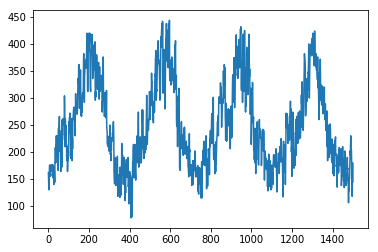

In [8]:
plt.plot(X)

In [9]:
def numDer(mi):
    mid = [(2*mi[i+1] - 3*mi[i] + mi[i-1])/dt for i in range(1,len(mi)-1)]
    mid.insert(0, (mi[1] - mi[0])/dt)
    mid.append((mi[-1] - mi[-2])/dt)
    return mid

In [10]:
def alpha(mi, mid):
    al1 = [X[i] - X[i-1] - mid[i-1]*dt for i in range(1,N)]
    al1 = [al1[i-1]*(mi[i-1] - X[i-1]) for i in range(1,N)]
    al1 = [al1[i-1]/X[i-1]**(2*gamma) for i in range(1,N)]
    al1 = np.sum(al1)
    al2 = [mi[i-1] -X[i-1] for i in range(1,N)]
    al2 = [al2[i-1]/X[i-1]**gamma for i in range(1,N)]
    al2 = [(al2[i-1]**2)*dt for i in range(1,N)]
    al2 = np.sum(al2)
    return al1/al2

In [11]:
def sigma(mi, mid, alpha):
    s1 = [X[i] - X[i-1] for i in range(1,N)]
    s2 = [(alpha*(mi[i-1] - X[i-1]) + mid[i-1])*dt for i in range(1,N)]
    s = [s1[i] - s2[i] for i in range(N-1)]
    s = [(s[i-1]/X[i-1]**gamma)**2 for i in range(1,N)]
    s = np.sum(s)
    s = np.sqrt((1/(N*dt))*s)
    return s    

In [12]:
import statsmodels.api as sm
s = 62500
cycle, trend = sm.tsa.filters.hpfilter(X,s)

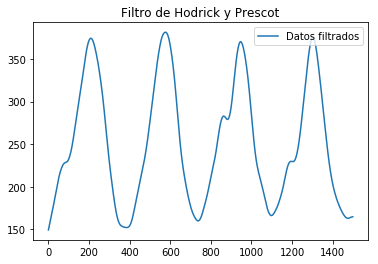

In [13]:
plt.plot(trend, label='Datos filtrados')
plt.legend(loc=1)
plt.title('Filtro de Hodrick y Prescot')
plt.show()

In [20]:
mid = numDer(trend)
alphae2 = alpha(trend, mid)
sigmae = sigma(trend, mid, alphae2)
print('alpha: ', alphae2)
print('sigma: ', sigmae)

alpha:  93.48422624765021
sigma:  1.5529193502587622


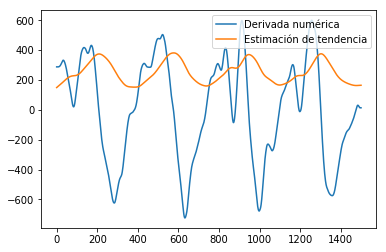

In [21]:
plt.plot(mid, label='Derivada numérica')
plt.plot(trend, label='Estimación de tendencia')
plt.legend(loc=1)
plt.show()

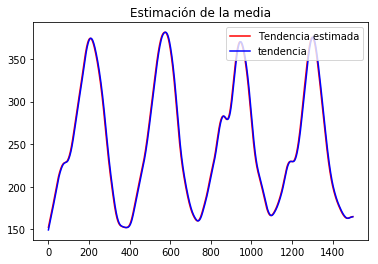

In [24]:
mut = [trend[i] + mid[i]/alphae2 for i in range(N)]
plt.plot(mut, 'red', label='Tendencia estimada')
plt.plot(trend, 'blue', label='tendencia')
plt.title('Estimación de la media')
plt.legend(loc=1)
plt.show()

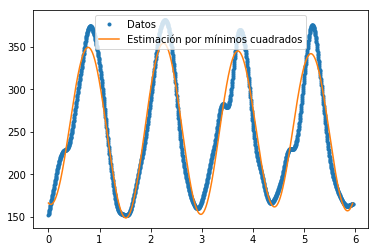

In [62]:
from scipy.optimize import leastsq

data = mut
t = np.linspace(0, N*dt, num=N)


optimize_func = lambda x: (x[0] + x[1]*np.sin(2*np.pi*t/x[2] + x[3]) + x[4]*np.cos(2*np.pi*t/x[5] + x[6]) + x[7]*np.cos(2*np.pi*t/x[8] + x[9]) - data)**2
a1, a2, a3, a4, a5, a6, a7, a8, a9, a10 = leastsq(optimize_func, np.ones(10))[0]

fine_t = np.arange(0,max(t),dt)
data_fit = a1 + a2*np.sin(2*np.pi*fine_t/a3 + a4) + a5*np.cos(2*np.pi*t/a6+a7) + a8*np.cos(2*np.pi*t/a9+a10)

plt.plot(t,data, '.', label='Datos')
plt.plot(fine_t, data_fit, label='Estimación por mínimos cuadrados')
plt.legend()
plt.show()

In [63]:
def alphae(muest):
    a1 = [(X[i] - X[i-1])*(muest[i-1] - X[i-1]) for i in range(1,N)]
    a1 = [a1[i-1]/(X[i-1]**(2*gamma)) for i in range(1,N)]
    a1 = np.sum(a1)
    a2 = [(((muest[i-1] - X[i-1])/X[i-1]**gamma)**2)*dt for i in range(1,N)]
    a2 = np.sum(a2)
    return a1/a2

In [64]:
def sigmae(muest, alphae11):
    s1 = [X[i] - X[i-1] for i in range(1,N)]
    s2 = [(alphae11*(muest[i-1] - X[i-1]))*dt for i in range(1,N)]
    s = [s1[i] - s2[i] for i in range(N-1)]
    s = [(s[i-1]/X[i-1]**gamma)**2 for i in range(1,N)]
    s = np.sum(s)
    s = np.sqrt((1/(N*dt))*s)
    return s 

In [65]:
muest = data_fit
alphae2 = alphae(muest)
sigmae2 = sigmae(muest, alphae2)
print('alpha', alphae2)
print('sigma', sigmae2)

alpha 67.29939080428991
sigma 1.6169566088837346


In [66]:
k = 1000
X1 = np.zeros((k,N))
X0 = X[0]
X1[:, 0] = X0
errores = []
for i in range(k):
    error = []
    for j in range(1,N):
        X1[i,j] = X[j-1] + alphae2*(muest[j-1] - X[j-1])*dt + sigmae2*X[j-1]*np.sqrt(dt)*np.random.normal()
        error.append(np.abs(X1[i,j] - X[j])/X[j])
    errores.append(np.mean(error))        

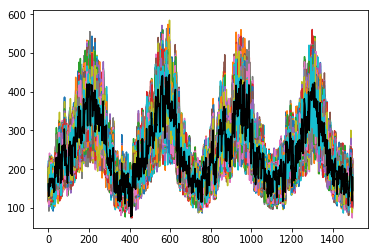

In [67]:
plt.plot(X1.T)
plt.plot(X, 'black')
plt.show()

In [68]:
np.mean(errores)

0.11460368539441748